<img src="https://github.com/alan-barzilay/NLPortugues/blob/master/imagens/logo_nlportugues.png?raw=true"  style="height:65%" align="right">


# Lista 7 - Atenção 
**Nome: Felipe de Lima Peressim**

**Numero Usp: 11823558**













______________

Nessa lista vamos implementar nosso próprio modelo de atenção para uma tarefa de tradução. Ao invés de traduzirmos entre linguagens naturais, nós vamos realizar uma tarefa de tradução muito mais simples: tradução de formatos de data. A tarefa é receber uma data em um formato qualquer e transforma-la em um formato padrão YYYY-MM-DD.

Optamos por essa abordagem para evitar termos que passar horas treinando um modelo em GPU, a ideia foi inspirada em um exercicio do curso _Sequence Models_ da DeepLearning.AI no Coursera.



Para essa lista também será util se familiarizar com a [API funcional do Keras](https://keras.io/guides/functional_api/) para construir modelos, algumas arquiteturas não são possiveis de serem expressadas como [modelos sequenciais]().


In [1]:
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model

from tensorflow import keras
import numpy as np

from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.utils import plot_model

# Dados

Utilizando a biblioteca Faker e Babel nós iremos gerar um dataset de datas aleatórias em formatos distintos, nosso objetivo é gerar um modelo capaz de traduzir estes formatos arbitrarios para nosso formato pré-estabelecido.

In [2]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)
Tx = np.max([len(dataset[i][0]) for i in range(len(dataset))])
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

100%|██████████| 10000/10000 [00:00<00:00, 23467.50it/s]


X.shape: (10000, 37)
Y.shape: (10000, 10)
Xoh.shape: (10000, 37, 39)
Yoh.shape: (10000, 10, 11)


In [3]:
index = 0
print("Data original:", dataset[index][0])
print("Data target:", dataset[index][1])
print()
print("Original após pré-processamento (indices):", X[index])
print("Target após pré-processamento (indices):", Y[index])
print()
print("Original após pré-processamento  (one-hot):", Xoh[index])
print("Target após pré-processamento  (one-hot):", Yoh[index])

Data original: 9 mai. 1998
Data target: 1998-05-09

Original após pré-processamento (indices): [13  0 24 14 21  2  0  5 13 13 12 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38 38 38 38 38 38 38 38]
Target após pré-processamento (indices): [ 2 10 10  9  0  1  6  0  1 10]

Original após pré-processamento  (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target após pré-processamento  (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# Atenção

Como comentamos em sala de aula, diversas funções de atenção existem, para nosso modelo vamos definir uma função simples que utiliza 2 camadas densas como função score.


## <font color='blue'>Questão 1 </font>


Defina a função `one_step_attention` que deve receber os stack de hidden states h da Bi-LSTM, que é um numpy-array de shape (m, Tx, 2*n\_a) e s\_prev, o ultimo hidden state da camada LSTM pós atenção, que é um numpy-array de shape (m, n\_s)

Utilize a camada [RepeatVector](https://keras.io/api/layers/reshaping_layers/repeat_vector/) para que h e s\_prev possuam as mesmas dimensões, em seguida [concatene](https://keras.io/api/layers/merging_layers/concatenate/) os arrays e use 2 camadas densas seguidas de uma ativação softmax. Por ultimo, realize uma combinação dos pesos de atenção obtidos dessa ultima camada de ativação com os hidden states h originais para gerar um vetor de contexto, a camada [Dot](https://keras.io/api/layers/merging_layers/dot/) será útil.

In [4]:
repeatVector = RepeatVector(Tx)
concatenate = Concatenate(axis=-1)
dense1 = Dense(10, activation = "tanh")
dense2 = Dense(1, activation = "relu")
activation = Activation('softmax', name='attention_weights')
dot = Dot(axes = 1)

def one_step_attention(h, s_prev):
    """
    Defina a função de atenção e retorne o vetor contexto 
    """
    s_prev = repeatVector(s_prev)
    concat = concatenate([h, s_prev])
    e = dense1(concat)
    energies = dense2(e)
    alphas = activation(energies)
    context = dot([alphas, h])
    
    return context

# Modelo

In [5]:
n_a = 32 
n_s = 64 

post_activation_LSTM_cell = LSTM(n_s, return_state = True) 
output_layer = Dense(len(machine_vocab), activation="softmax")

def cria_modelo(Tx, Ty, human_vocab_size, machine_vocab_size,n_a=32, n_s=64):
    
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    outputs = []
    # Para mais detalhes sobre return_sequences e outros parametros das RNNs no Keras,
    # recomendamos este guia da documentação oficial https://keras.io/guides/working_with_rnns/
    h = Bidirectional(LSTM(n_a, return_sequences = True))(X) # Encoder
    
    for t in range(Ty):
        #Decoder
        context = one_step_attention(h, s)
        s, _, c = post_activation_LSTM_cell(context, initial_state = [s, c])
        out = output_layer(s)
        outputs.append(out)
    
    model = Model(inputs = [X, s0, c0], outputs = outputs)
    
    return model


In [6]:
model = cria_modelo(Tx, Ty, len(human_vocab), len(machine_vocab))

model.compile(optimizer = "adam",
                            metrics = ['accuracy'],
                            loss = 'categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 37, 39)]     0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 37, 64)       18432       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 37, 64)       0           s0[0][0]                         
                                                                 lstm[0][0]                   

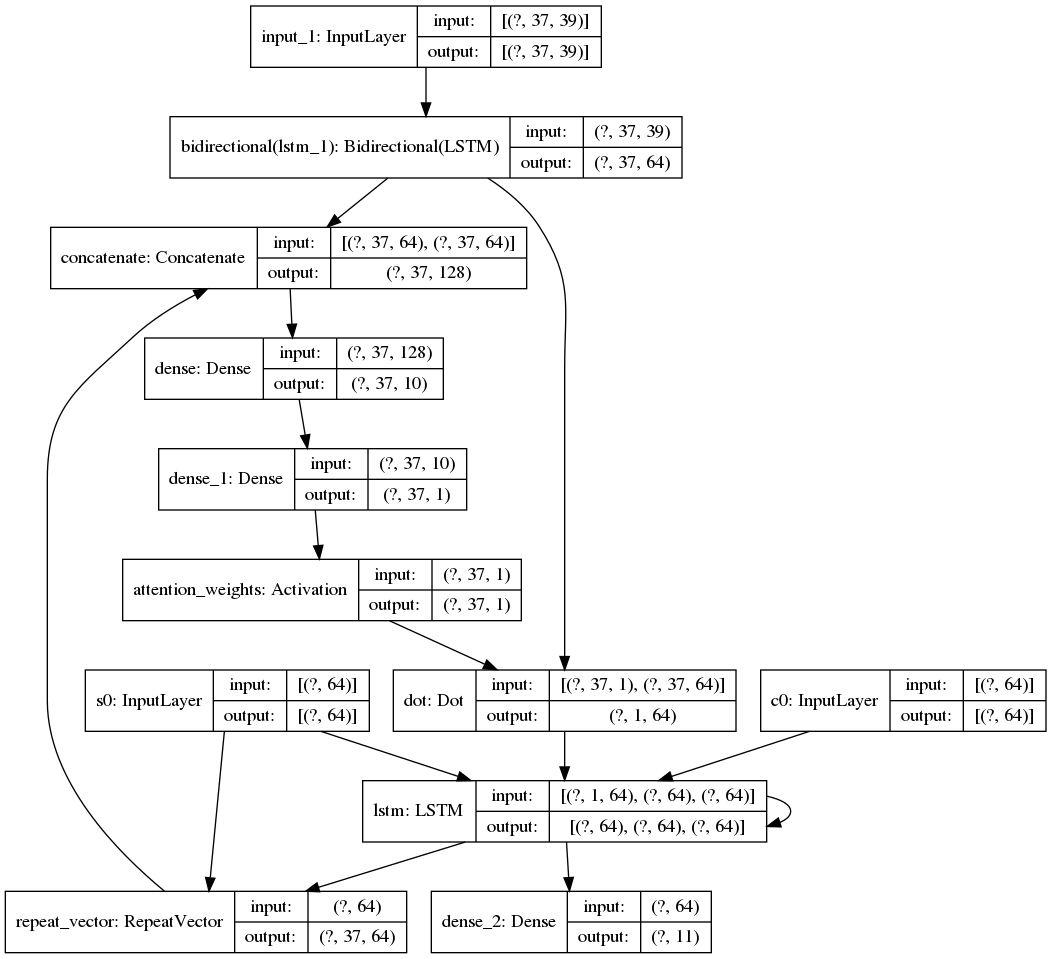

In [7]:
plot_model(model, show_shapes=True, show_layer_names=True)

Seu modelo deve ficar com uma arquitetura semelhante a esta:

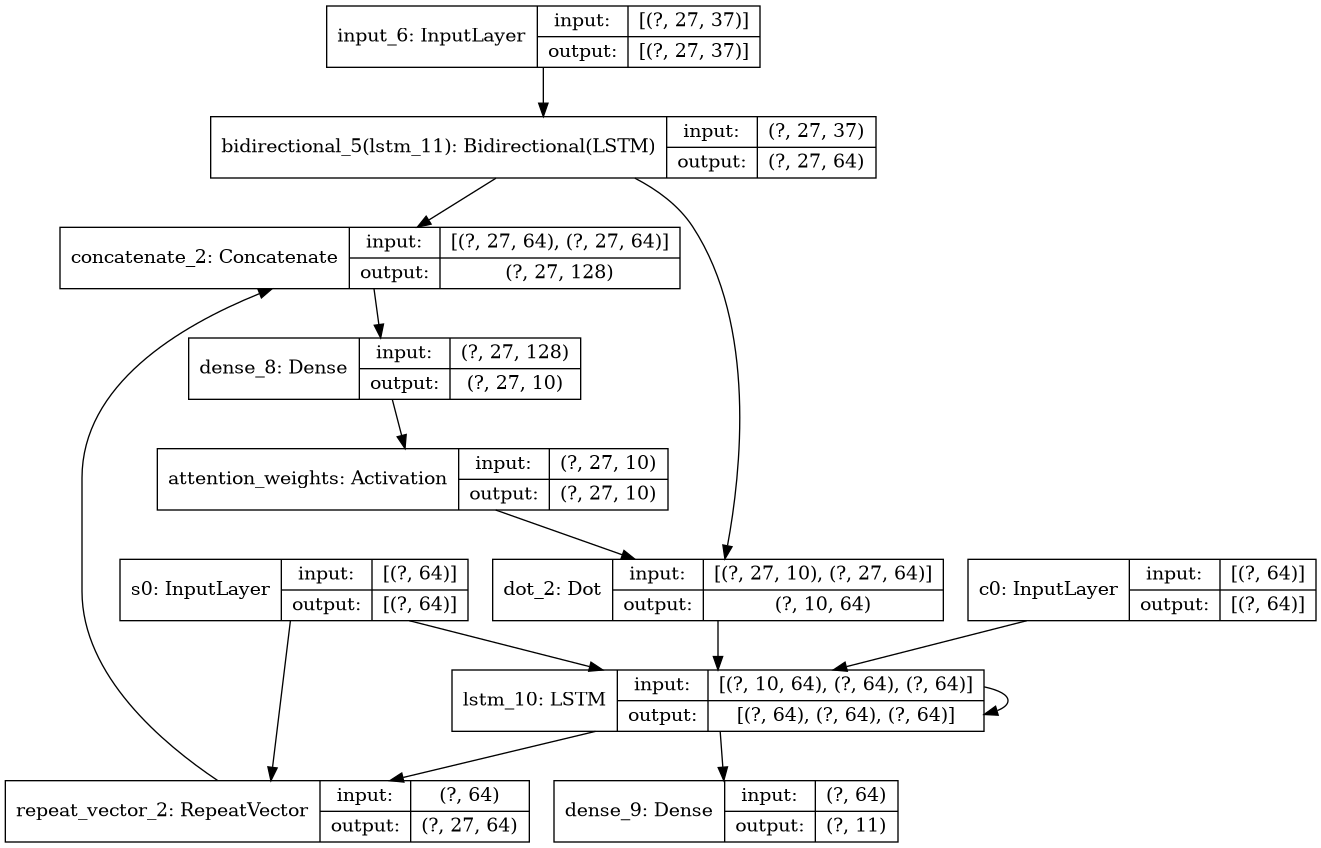

# Treinar

In [8]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

model.fit([Xoh, s0, c0], outputs, epochs=20, batch_size=100 )

Epoch 1/20
100/100 [==============================] - 7s 73ms/step - loss: 18.6764 - dense_2_loss: 1.4563 - dense_2_1_loss: 1.2668 - dense_2_2_loss: 1.8822 - dense_2_3_loss: 2.5863 - dense_2_4_loss: 1.4134 - dense_2_5_loss: 1.6152 - dense_2_6_loss: 2.5417 - dense_2_7_loss: 1.3228 - dense_2_8_loss: 1.8867 - dense_2_9_loss: 2.7051 - dense_2_accuracy: 0.4935 - dense_2_1_accuracy: 0.6726 - dense_2_2_accuracy: 0.3253 - dense_2_3_accuracy: 0.1432 - dense_2_4_accuracy: 0.5620 - dense_2_5_accuracy: 0.2435 - dense_2_6_accuracy: 0.0734 - dense_2_7_accuracy: 0.6769 - dense_2_8_accuracy: 0.1561 - dense_2_9_accuracy: 0.0747
Epoch 2/20
100/100 [==============================] - 7s 66ms/step - loss: 13.8983 - dense_2_loss: 0.3794 - dense_2_1_loss: 0.3964 - dense_2_2_loss: 1.1203 - dense_2_3_loss: 2.2505 - dense_2_4_loss: 0.8516 - dense_2_5_loss: 1.4459 - dense_2_6_loss: 2.3447 - dense_2_7_loss: 1.3433 - dense_2_8_loss: 1.5789 - dense_2_9_loss: 2.1874 - dense_2_accuracy: 0.9426 - dense_2_1_accuracy: 0

100/100 [==============================] - 7s 74ms/step - loss: 1.5901 - dense_2_loss: 0.0531 - dense_2_1_loss: 0.0434 - dense_2_2_loss: 0.2768 - dense_2_3_loss: 0.2877 - dense_2_4_loss: 0.0045 - dense_2_5_loss: 0.0678 - dense_2_6_loss: 0.3072 - dense_2_7_loss: 0.0059 - dense_2_8_loss: 0.2393 - dense_2_9_loss: 0.3044 - dense_2_accuracy: 0.9812 - dense_2_1_accuracy: 0.9832 - dense_2_2_accuracy: 0.8744 - dense_2_3_accuracy: 0.9060 - dense_2_4_accuracy: 1.0000 - dense_2_5_accuracy: 0.9774 - dense_2_6_accuracy: 0.9128 - dense_2_7_accuracy: 1.0000 - dense_2_8_accuracy: 0.9129 - dense_2_9_accuracy: 0.8947
Epoch 15/20
100/100 [==============================] - 7s 66ms/step - loss: 1.4755 - dense_2_loss: 0.0506 - dense_2_1_loss: 0.0424 - dense_2_2_loss: 0.2676 - dense_2_3_loss: 0.2635 - dense_2_4_loss: 0.0040 - dense_2_5_loss: 0.0650 - dense_2_6_loss: 0.2806 - dense_2_7_loss: 0.0053 - dense_2_8_loss: 0.2243 - dense_2_9_loss: 0.2722 - dense_2_accuracy: 0.9823 - dense_2_1_accuracy: 0.9824 - dens

# Validar

In [9]:
teste,_ ,_,_  = load_dataset(30)
teste = [teste[i][0] for i in range(len(teste))]

for example in teste:
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(
        list(
            map(lambda x: to_categorical(x, num_classes=len(human_vocab)),
                source)))

    source = source.reshape((1, Tx, len(human_vocab)))
    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))

    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis=-1)
    output = [inv_machine_vocab[int(i)] for i in prediction]

    print("input:", example)
    print("output:", ''.join(output), "\n")

100%|██████████| 30/30 [00:00<00:00, 5126.26it/s]


input: 9 agosto 1983
output: 1983-08-09 

input: quinta-feira 10 de agosto de 1978
output: 1977-08-10 

input: quinta-feira 23 de julho de 2015
output: 2015-07-23 

input: 07/02/97
output: 1977-02-07 

input: quarta-feira 28 de novembro de 2001
output: 2010-11-28 

input: segunda-feira 6 de novembro de 1989
output: 1999-11-06 

input: 14 jan. 2004
output: 2004-01-14 

input: 1 01 81
output: 2011-01-01 

input: terça-feira 29 de abril de 1975
output: 1975-04-29 

input: segunda-feira 30 de abril de 1973
output: 1973-04-30 

input: 25 maio 1982
output: 1982-05-25 

input: sexta-feira 13 de novembro de 1992
output: 1992-11-13 

input: sábado 13 de março de 2004
output: 2004-03-13 

input: 05 dez. 2019
output: 2019-12-05 

input: segunda-feira 21 de junho de 1971
output: 1971-06-11 

input: quarta-feira 31 de março de 1971
output: 1971-03-11 

input: agosto 4 2011
output: 2011-08-04 

input: 31 de março de 1990
output: 1990-03-33 

input: 12 de outubro de 2017
output: 2017-10-12 

input: m